# Relation Extraction with gpt-4o and Retrieval Augmented Generation

One big issue with using generative LLMs is their tendency to hallucinate. When we create a chatbot for example, this feature may be problematic in cases where we need factually correct replies to our queries. Say we want to build a chatbot system to answer questions about a historical figure - we would expect models to produce output which is **historically accurate**, up to date with the latest research findings, and not simply a stochastic product of the model's training data.

There are several ways to mitigate this tendency of the models to hallucinate. We could play with the **temperature** parameter of our model to combat the production of less probable answers - or we could use **Retrieval Augmented Generation (RAG)**. While its lofty name may lead you to believe otherwise, the idea behind RAG is quite straightforward: rather than only relying on the model's training data to produce output, we connect the model to a **database of vectorized texts** containing relevant background information to our query, and insert them in our prompt. This way, the model can base its answer on this extra information to generate correct output. The quality of our vectorized texts and the quality of the retrieval process thus becomes quite significant. If the fetched texts are wrong, the model will be side-tracked and produce wrong output.

In this notebook, we will show you how to use a RAG-based pipeline to extract relationships between interlocutors from a historical corpus of letters from the 19th-century Flemish wordsmith and priest **Guido Gezelle** (1830-1899). These relationships are presented as multiple class labels.

We will do this using the model gpt-4o, accessed through the OpenAI API.

We will take the following steps:

1. Create a vector database where we store our relevant texts and appropriate metadata using [Chroma](https://www.trychroma.com/) vector stores.
2. Create a prompt to extract relationships from our letters using the [OpenAI API](https://openai.com/index/openai-api/) and the model gpt-4o.
3. Evaluate our retrieval step using **Mean Average Precision**.
4. Visualize the AI's explanations in a WordCloud.
5. Visualize our extracted relationships with PyVis.

## ❓Why is this useful for the historian?

If you think about it, the process of collecting background information to query a corpus is in line with how a historian would work. They, too, gather a lot of background information - and then methodically process this corpus to eventually answer a research question.

If we develop a good RAG-system for a specific literary-historical domain, we could create **informed automated annotators** to create large-scale silver-labeled datasets to train discriminative AI systems.




## Required background knowledge 🧠

❗🎓 To adapt and use this Notebook to produce relationships for your own texts, you need to have an intuitive understanding of the following concepts:

  * Relation Extraction.
  * Retrieval Augmented Generation (RAG).
  * Generative AI.
  * Evaluation metrics (precision, recall, F1).
  * Text embeddings.
  * Vector stores.
  * GitHub.
  * [LangChain](https://www.langchain.com/)
  * Zero-shot prompting.


To adapt the code, you need to know about:

* Functions in Python.
* Classes in Python.
* Pandas dataframe operations.
* Jupyter Notebooks.

# Setting our environment

First of all, you'll need to **add your OpenAI API key** to the Colab environment and grant Notebook access to your key. You can click the key on the left to add your key name and value, and load it in using **userdata.get** function.


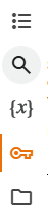



In [1]:
!pip install langchain_openai
!pip install chromadb
!pip install pyvis
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [2]:
from google.colab import userdata

from openai import OpenAI
import os

from langchain_openai import ChatOpenAI
import chromadb.utils.embedding_functions as embedding_functions
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import json
from langchain_core.prompts import ChatPromptTemplate
from pyvis.network import Network

import pandas as pd
import chromadb
import time

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import spacy
from ast import literal_eval

In the code snippets below we load in the model and the data we will be using from our GitHub.

In [3]:
model = ChatOpenAI(model="gpt-4o",
    temperature=0, #we set the temperature to 0 to get the most "probable" answer.
    seed = 42,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=userdata.get("OPENAI_API_KEY") #add the API key from our key values
    )

In [4]:
!git clone https://github.com/GhentCDH/CLSinfra.git

Cloning into 'CLSinfra'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 190 (delta 61), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (190/190), 19.26 MiB | 4.78 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (68/68), done.


# Our corpus: Guido Gezelle's correspondence

The corpus we will use to showcase our approach is a beautiful dataset of letters written to and from **Guido Gezelle**, a renowned 19th century poet, priest and political figure. This corpus was collected, digitised and enriched with historical information by the impressive [Gezelle project](https://gezelle.be/). The letters, their digital editions and historical annotations can be explored online through [GezellebrOn](https://edities.kantl.be/gezelle/index.htm), and are **multilingual**, written in predominantely Flemish Dutch, French and English, but also Latin.

## Testing gpt-4o's knowledge

Let's see what gpt-4o, at the time of writing one of the most powerful and vast LLMs, knows about Guido Gezelle and his niece, [Dymphna Gezelle](https://gezelle.be/biografisch-plein/dymphna-gezelle)!


In [5]:
model.predict("Who is Guido Gezelle?")

<ipython-input-5-fd8f7797b8d7>:1: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  model.predict("Who is Guido Gezelle?")


"Guido Gezelle was a Flemish poet and Catholic priest, born on May 1, 1830, in Bruges, Belgium, and died on November 27, 1899. He is considered one of the most important figures in 19th-century Flemish literature. Gezelle wrote primarily in Dutch, and his work is known for its lyrical quality, religious themes, and deep connection to nature. He was also a linguist and a teacher, and his poetry often reflects his interest in the Flemish language and culture. Gezelle's influence extends beyond literature, as he played a significant role in the Flemish Movement, which sought to promote the Dutch language and Flemish identity in Belgium."

Cool! As we can see, the model seems to contain some knowledge about Guido Gezelle. Let's see how much the model knows about a more obscure figure, his niece Dymphna Gezelle.

In [6]:
model.predict("Who is Dymphna Gezelle?")

"As of my last update, there is no widely recognized public figure or notable individual by the name of Dymphna Gezelle. It's possible that this person could be a private individual or someone who has gained recognition after my last update. If you have more context or details about who this person might be, I might be able to help further."

Interesting, clearly - despite the vast training data of our model, there is no information about Dymphna Gezelle. If we build a relation extraction system, ideally, it could be useful for our system to have access to the historically correct biographical information gathered by the Gezelle institute.

This is precisely where our RAG-system comes in!

# Building a vector database with Chroma

In building a vector database, the main idea is to vectorize texts which can serve as relevant information to insert in our prompt. There are multiple ways to build a vector database.
[Chroma](https://www.trychroma.com/), which we will use, is one example of an application, but we can also use FAISS or Pinecone embeddings, for example.

Let's load in the biographical texts and extra metadata which we want to use to populate our Chroma vector database. We have the following information:
1. **A person ID** (e.g.: persoon0001).
2. **The person's name** (e.g.: Alberdingk Thijm).
2. **A biographical text**.


In our vector store, we want to include the biographical texts (Wikipedia pages and bios) and link it to the metadata (the person ID). The latter will be used in a later stage to evaluate the retrieval step. The way you evaluate the quality of your retrieval step depends on the goal of your system. Here, we will assume that a retrieval was correctly done if the person ID overlaps with the IDs present in the metadata of the letter which we will feed to the prompt.

In [6]:
df_people = pd.read_csv("/content/CLSinfra/Example_data_CLS/df_people_subset.csv")

In [7]:
df_people.sample(5)

,person_id,person_name_full,surname,forename,relationship,bio,wiki_page,merged_texts
783,persoon1661,"Telford, John",Telford,John,no_relationship,In dienst van St. George's Cathedral van augus...,no_wiki,In dienst van St. George's Cathedral van augus...
583,persoon1261,"Marichal, Camiel Hector",Marichal,Camiel Hector,['correspondent'],Camiel Marichal studeerde aan het kleinseminar...,no_wiki,Camiel Marichal studeerde aan het kleinseminar...
1690,persoon3002,"Fockenier, Anna Maria Amelia",Fockenier,Anna Maria Amelia,no_relationship,Anna Maria Amelia was de dochter van Maria Reg...,no_wiki,Anna Maria Amelia was de dochter van Maria Reg...
1520,persoon2788,"Janssens de Varebeke, Jozef Maria Aloys",Janssens de Varebeke,Jozef Maria Aloys,no_relationship,Jozef Janssens was de oudste zoon van volksver...,Jozef Maria Aloys Janssens (vanaf 1912 met toe...,Jozef Janssens was de oudste zoon van volksver...
1292,persoon2515,"Praet, Jan",Praet,Jan,no_relationship,Jan Praet was een Westvlaams middeleeuws dicht...,no_wiki,Jan Praet was een Westvlaams middeleeuws dicht...


In [8]:
print("Biographical text of Maria Regina Mahieu:")
df_people.iloc[11]['merged_texts']

Biographical text of Maria Regina Mahieu:


"Maria Regina Mahieu werd geboren te Roeselare 6 aug 1808 als dochter van Ferdinand Mahieu (Kortemark 1776 - Roeselare 1818) en Maria Regina De Geest (Roeselare 1772- Roeselare 1853). Op 7 juni 1832 trad Maria Regina Mahieu in het klooster van de benedictinessen, bekend als de Sint-Godelieve-abdij in de Bouveriestraat te Brugge. Ze werd gekleed op 12 september 1832 en legde haar plechtige geloften af op 23 september 1833. Maria Regina diende als abdis van de abdij vanaf 15 mei 1855 tot aan haar overlijden op 6 november 1876 te Brugge. Guido Gezelle schreef het gedicht 'De roep des Heeren' ter gelegenheid van haar wijding als abdis. no_wiki"

In [9]:
# fetch the docs to feed to the database (docs_people) and the ids (ids_people)

docs_people = list(df_people["merged_texts"])
ids_people = list(df_people["person_id"])

metadatas_people = [{"person_id": x} for x in ids_people]
ids = ["text_id_" + str(x) for x in range(len(docs_people))]

## Populate the Chroma database

To vectorize our texts, we need to define an embedding function. Here, we're using the OpenAIEmbeddingFunction (openai_ef) to create high-quality vectors of each input text. We know that the OpenAI embeddings can handle multilingual text. To make a vdb, we need to take the following steps:

1. Load in and chunk the texts in smaller bits using the **RecursiveCharacterTextSplitter**.
2. Add the texts and the metadata to our **Chroma vdb collection**. We add the person ID as metadata.


🤔 Using the RecursiveCharacterTextSplitter, we chunk longer texts into smaller bits. However, the length of our chunk will have an impact on the information we retrieve! You can play with this paramater to see which one works best for your goals. At the time of creating this Notebook, LangChain is also creating a [Semantic Text chunker](https://python.langchain.com/docs/how_to/semantic-chunker/), which chunks the texts based on semantic similarity.

In [19]:
# define the client
#chroma_client = chromadb.Client()

In [7]:
# we want our data to be stored locally
client = chromadb.PersistentClient(
    path="/content/vdb_Gezelle/"
    )

In [8]:
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key= userdata.get("OPENAI_API_KEY"),
                model_name="text-embedding-3-small"
            )

In [9]:
# create a collecction

collection = client.create_collection(name="Gezelle_vdb", embedding_function= openai_ef)

In [ ]:
# split texts in chunks

splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=32, length_function=len)

In [ ]:
# split in chunks of chunk size (see above)
docs = []
for doc_person, doc_ids, id in zip(docs_people, ids_people, ids):
    for chunk in splitter.split_text(doc_person):
        docs.append(Document(page_content = chunk, metadata = {"person_id": doc_ids, "id": id}))

In [ ]:
docs[0]

Document(metadata={'person_id': 'persoon0006', 'id': 'text_id_0'}, page_content='Renatus Franciscus Adriaens was de zoon van Henri Adriaens en Sophie-Rosalie Coene. Hij studeerde aan het kleinseminarie te Roeselare en was er klasgenoot van Rodenbach in de wonderklassen Poësis (1874-75) en Rhetorica (1875-76) bij Hugo Verriest, die hem samen met drie andere klasgenoten, onder wie Rodenbach, portretteerde in zijn "Twintig Vlaamsche Koppen" (1923). Hij was er lid van de lettergilde (Société Littéraire) en werkte er mee, samen met Rodenbach, aan de Nederlandse vertaling van het Griekse treurspel "Prometheus in de boeien" van Aeschylos. Na studies in de geneeskunde in Leuven vestigde hij zich als geneesheer in Zedelgem. Hij was abonnee van Biekorf en correspondent van Gezelle. Als dokter te Zedelgem was hij betrokken bij het dialectonderzoek Gezelle-Willems. no_wiki')

In [ ]:
person_ids_chunks = [{"person_id": doc.metadata["person_id"]} for doc in docs]
fulltext_chunks = [doc.page_content for doc in docs]
text_ids_chunks = ["text_id_" + str(x) for x in range(len(fulltext_chunks))]

In [ ]:
def splitlist(l, n):
    x = [l[i:i + n] for i in range(0, len(l), n)]
    return x

In [ ]:
#we can't add all the elements at once, because of the rate limit
#split into lists of length 500

part_meta = splitlist(person_ids_chunks, 500)
part_fulltext = splitlist(fulltext_chunks, 500)
part_text_ids = splitlist(text_ids_chunks, 500)

In [ ]:
# add to collection database in parts, to avoid rate limit OpenAI

for pm, pft, ptid in zip(part_meta[1:], part_fulltext[1:], part_text_ids[1:]):
    # feed the people_df docs and metadatas to the collection database
    collection.add(
        documents = pft,
        metadatas = pm,
        ids = ptid
    )
    time.sleep(10)

## Fetch relevant texts from the vector database

Let's launch a query for our freshly created vector database and see how it works!

In [ ]:
results = collection.query(
    query_texts = ["Give me information about Frans Rens."],
    n_results = 2
)

In [ ]:
results

{'ids': [['text_id_5541', 'text_id_5205']],
 'embeddings': None,
 'documents': [['Frans Rens werkte als belastingambtenaar en inspecteur lager onderwijs, maar werd bekend als letterkundige. Hij publiceerde al vanaf 1827 gedichten te Eeklo, maar na zijn verhuizing naar Gent in 1932 ook prozawerk. Daarnaast was hij (hoofd)redacteur voor een aantal vooraanstaande geschiedkundige en literaire tijdschriften. Hij was ook medestichter van het Vlaemsch Gezelschap (1846) en hij werd in 1851 lid en later voorzitter (1862-1874) van het Willemsfonds. Hij werd benoemd tot Ridder in de Leopoldsorde. Frans Rens kan verwijzen naar:\n\nFrans Rens (letterkundige) (1805–1874), Belgisch-Nederlandstalig letterkundige\nFrans Rens (notaris) (1865–1940), Belgisch notaris en politicus',
   "Hoogleraarschap te Franeker\nVan 1771 tot zijn overlijden in 1826 was hij verbonden aan de Franeker universiteit, alwaar hij enkele jaren rector-magnificus was, en vanaf 1797 ook Nederlands doceerde. Onder zijn studenten be

🧐 Remember our example where we asked the model who Dymphna Gezelle was? Let's see if the information we can fetch from our vector database can help the model answer this question correctly.

In [173]:
results = collection.query(
    query_texts = ["Give me information about Dymphna Gezelle."],
    n_results = 2
)

In [174]:
results

{'ids': [['text_id_891', 'text_id_892']],
 'embeddings': None,
 'documents': [["Dymphna Gezelle werd geboren te Brugge in 1873. Ze was de dochter van Romaan Gezelle en Philomena de Smet, en zodus de nicht van Guido Gezelle. In 1896 trad ze in bij de Zusters van Liefde, waar ze op 14 december 1897 haar geloften aflegde als Maria Wilfine. In januari 1898 kwam ze toe in Brits-Indië, waar ze als missiezuster werkte, eerst in Lahore, en later ook in het Sint-Vincentiusklooster te Khushpur, waar ze overste was vanaf 1902. Na haar terugkeer naar België in 1912, ging ze eerst naar Melle (Caritas ) en Brugge (Sint-Antonius van Padua) alvorens in 1914 naar het klooster met psychiatrisch ziekenhuis van de Zusters van Liefde te Sint-Truiden te gaan. Daar verzorgde ze de 'zinnelozen'. Ze kreeg echter kanker en stierf te Leuven op 15 januari 1937.",
   'Florence Gezelle, dochter van Pieter-Jan Gezelle, hovenier, en Monica Devriese, was de jongste zus van Guido Gezelle. Ze woonde bij haar broer in to

# Prompting: extracting relationships with gpt-4o

In this section, we are constructing the pipeline to create the relationship labels. Based on 1) the letter, 2) an annotation guide with expected relationship labels and 3) the retrieved information from our freshly created vector database, we want to make the model return one or multiple labels in the following categories - which were constructed based on contextual background knowledge of the letters at hand:

*   Acquaintance
*   Friend
*   Church
*   School
*   Family
*   Literary

In this section we'll create the **prompt** itself, and a **class instance** to run our relation extraction pipeline across our dataset. We want the pipeline to output the **relationship labels** and an **explanation**.

Relation extraction is complex! We know that sometimes interlocutors will appear multiple times, and thus our letter-based REX-pipeline will extract multiple relationships. Each letter may give the model a bit more information to allot a new label to a pair. In the end, we make sure that we concatenate all the given relationship labels per said pair!

❗Mind the gap: I ran the code below by using a version of the Chromadb collection which is populated with all the people included in the Gezelle project. You do not have access to this, so don't worry if your results are not on par with your expectations.




In [10]:
#let's see which collections we already have in our Client!
client.list_collections()

['Gezelle_vdb', 'langchain']

In [11]:
#load in collection using Chroma
collection = client.get_collection(name="Gezelle_vdb", embedding_function=openai_ef)

In [27]:
type(collection)

chromadb.api.models.Collection.Collection

In [12]:
letters = pd.read_csv("/content/CLSinfra/Example_data_CLS/part_dev.csv")

In [13]:
letters.head()

,ID,annotated_entities,letter,language,senders_id,senders_names,receivers_id,receivers_names,places_names,places_names_id,insts_names,insts_names_id,relationship_labels
0,12358,['J. Scherpenseel Consul Generaal Der Zuid-Afr...,\n-J. Scherpenseel Consul Generaal Der Zuid-Af...,Nederlands,['persoon1572'],"['Scherpenseel, Peter Jozef']",['persoon0905'],"['Gezelle, Guido']","['Brussel', 'Kortrijk']","['plaats0160', 'plaats0550']",['Koninklijke Vlaamsche Academie'],['instelling0019'],"['LITERARY', 'ACQUAINTANCE']"
1,12352,"['Th. Coopman', 'Den WelEdel. Heere Guido Geze...",\nDen WelEdel. Heere Guido Gezelle {<=pastr.>[...,Nederlands,['persoon0368'],"['Coopman, Theofiel']",['persoon0905'],"['Gezelle, Guido']",['Kortrijk'],['plaats0550'],"[""'s Konings Taalkamer""]",['instelling0019'],['LITERARY']
2,12281,"[""26 Febr., '88"", 'Gent', 'Collega', 'Kortrijk...","\nGent, 26 Febr., '88. Mijn waarde Collega, Er...",Nederlands,['persoon0736'],"['De Vos, Amand']",['persoon0905'],"['Gezelle, Guido']","['Gent', 'Kortrijk', 'Leuven']","['plaats0304', 'plaats0550', 'plaats0608']",['Academie'],['instelling0019'],['LITERARY']
3,12272,"['Brussel', '10n Kortemaand 1888', 'Eerweerde ...",\nBrussel 10n Kortemaand 1888 Eerweerde Heer. ...,Nederlands,['persoon1742'],"['Van Damme, Joseph']",['persoon0633'],"['Demonie, Emiel']",['Brussel'],['plaats0160'],['Vlaamsche Taalkamer'],['instelling0019'],"['LITERARY', 'ACQUAINTANCE', 'SCHOOL']"
4,12271,"['Luik', '8 february 1888', 'Eerwaarde Heer en...",\nLuik den 8 february 1888 Wel Eerwaarde Heer ...,Nederlands,['persoon1512'],"['Roersch, Lodewijk']",['persoon0905'],"['Gezelle, Guido']",['Luik'],['plaats1354'],[],[],['LITERARY']


## 🚀 Construct prompt and query

In [14]:
# We always add Guido Gezelle's biography in the prompt for context
GUIDO_BIO = df_people[df_people["person_id"] == "persoon0905"]["bio"].iloc[0]

In [15]:
GUIDO_BIO

'Guido Gezelle werd geboren in Brugge. Na zijn collegejaren en priesterstudies (priesterwijding te Brugge op 10/06/1854), werd hij in 1854 leraar aan het kleinseminarie te Roeselare. Gezelle gaf er onder meer talen, begeleidde de vrij uitgebreide kolonie buitenlandse leerlingen, vooral Engelsen, en kreeg tijdens twee schooljaren (1857-1859) een opdracht als leraar in de poësis. In 1865 werd Gezelle onderpastoor van de St.-Walburgaparochie te Brugge. Naast zijn druk pastoraal werk was hij bijzonder actief in het katholieke ultramontaanse persoffensief tegen de secularisering van het openbare leven in België en als vulgarisator in het culturele weekblad Rond den Heerd. In 1872 werd Gezelle overgeplaatst naar de O.-L.-Vrouwparochie te Kortrijk. Gedragen door een sympathiserende vriendenkring werd hij er de gelegenheidsdichter bij uitstek. Gaandeweg keerde hij er ook terug naar zijn oorspronkelijke postromantische en religieus geïnspireerde interesse voor de volkstaal en de poëzie. De taal

In [16]:
ANNOTATION_GUIDE = {
    "ACQUAINTANCE": "correspondents who know each other but do not have an intimate relationship",
    "FRIEND": "correspondents who have an intimate, friendly relationship.",
    "CHURCH": "correspondents who have a relationship which is related to church work. They can be confessants, related to the seminary, or priests for example.",
    "SCHOOL": "correspondents who have a connection through teaching or school work.",
    "FAMILY": "correspondents who are family.",
    "LITERARY": "correspondents who have a connection based on exchanging and discussing literary works or exchanging poetry or words. They can also be part of literary organisations such as KANTL, Rond Den Heerd, Loquela or Biekorf."
}

In [17]:
PROMPT_LINK_NER = """You are trained to recognize relationships in letters.

This is a letter from the collection of Guido Gezelle's correspondence:
{LETTER}.

Here is some background information on Guido Gezelle to help you:
{GUIDO_BIO}

Here is some context to help:
{RELEVANT_DOCS}

Based on the letter and the context information, extract the relationship between the sender and the receiver in the letter.
The relationships you can choose from are OTHER, ACQUAINTANCE, FRIEND, CHURCH, FAMILY, LITERARY and SCHOOL.
You can pick multiple relationships.

Here is the annotation guide you can use:
{ANNOTATION_GUIDE}

Explain your answer, and explain which information you used to come to your conclusion.
Structure your output according to the format below. Do not add anything else.

RESULT:
{JSON_RELATIONSHIPS}

"""

In [18]:
JSON_RELATIONSHIPS ="""{"result": {"RELATIONSHIPS": ["sender_name"], "EXPLANATION": ["explanation"]}}"""

In [94]:
class LetterRelationshipExtractor:
    def __init__(self, model, collection, annotation_guide, json_relationships, guido_bio):
        """
        Initializes the extractor.

        :param model: The language model used for prompt completion.
        :param collection: The document collection for querying relevant docs.
        :param annotation_guide: The annotation guide for relationships.
        """
        self.model = model
        self.collection = collection
        self.annotation_guide = annotation_guide
        self.json_relationships = json_relationships
        self.guido_bio = guido_bio
        self.prompt_template = ChatPromptTemplate.from_template(self._get_prompt_template())


    @staticmethod
    def _get_prompt_template():
      return PROMPT_LINK_NER

    def _get_relevant_docs(self, sender, receiver):
        """
        Queries the collection for relevant documents based on sender and receiver.

        :param sender: The sender's name.
        :param receiver: The receiver's name.
        :return: Relevant documents as a string.
        """
        query = f"Return information about {sender} and {receiver}"
        result = self.collection.query(query_texts=query, n_results=5)
        return result["documents"], result["metadatas"]

    def _get_metadata_relevant_docs(self, metadatas):
      print(metadatas)
      extracted_metadata = list(set([list(x.values())[0] for x in metadatas[0]]))
      print(extracted_metadata)

      return extracted_metadata

    def extract_relationships(self, letter, sender, receiver):
        """
        Extracts relationships from a letter.

        :param letter: The letter text.
        :param sender: The sender's name.
        :param receiver: The receiver's name.
        :return: Extracted relationships as a string.
        """

        relevant_docs, relevant_metadatas = self._get_relevant_docs(sender, receiver)
        extracted_metadata = self._get_metadata_relevant_docs(relevant_metadatas)
        prompt = self.prompt_template.invoke({"LETTER": letter,
                                              "GUIDO_BIO": self.guido_bio,
                                              "JSON_RELATIONSHIPS": self.json_relationships,
                                              "RELEVANT_DOCS": relevant_docs,
                                              "ANNOTATION_GUIDE": self.annotation_guide})
        response_text = self.model.invoke(prompt)
        prep_parsed_response = response_text.content.split("RESULT:")[-1].strip("\n")

        return prep_parsed_response, extracted_metadata

    def response_to_json(self, prep_parsed_response):
      print(prep_parsed_response)
      try:
            return json.loads(prep_parsed_response)
      except json.JSONDecodeError:
            print(prep_parsed_response)
            raise ValueError("The response text is not a valid JSON format.")


    def process_dataframe(self, df, letter_col, sender_col, receiver_col):
        """
        Processes a dataframe of letters to extract relationships for each row.

        :param df: The dataframe containing letters and metadata.
        :param letter_col: Column name for the letter content.
        :param sender_col: Column name for the sender's name.
        :param receiver_col: Column name for the receiver's name.
        :param bio_col: Column name for Guido Gezelle's bio.
        :return: A new dataframe with an added 'relationships' column.
        """
        relationships = []
        explanations = []
        extracted_metadatas = []

        for _, row in df.iterrows():
            letter = row[letter_col]
            sender = eval(row[sender_col])[0]
            receiver = eval(row[receiver_col])[0]


            # Extract relationships for each letter
            attempt = 0
            max_attempts = 3
            while attempt < max_attempts:
                try:
                    prep_response_text, extracted_metadata = self.extract_relationships(letter, sender, receiver)
                    relationship = self.response_to_json(prep_response_text)
                    break
                except ValueError as e:
                    attempt += 1
                    if attempt == max_attempts:
                        relationship = {"error": str(e)}

            extracted_metadatas.append(extracted_metadata)
            relationship_labels = relationship["result"]["RELATIONSHIPS"]
            relationship_explanations = relationship["result"]["EXPLANATION"]
            relationships.append(relationship_labels)
            explanations.append(relationship_explanations)

        # Add the results to the dataframe
        df = df.copy()
        df['relationships'] = relationships
        df['explanations'] = explanations
        df['extracted_metadata'] = extracted_metadatas

        return df


    def merge_relationships_by_pair(self, df, sender_col, receiver_col):
        """
        Merges relationship labels for rows with the same sender-receiver pair.

        :param df: The dataframe containing letters and relationships.
        :param sender_col: Column name for the sender's name.
        :param receiver_col: Column name for the receiver's name.
        :return: A new dataframe with merged relationships for the same sender-receiver pairs.
        """
        # Group by sender-receiver pairs and concatenate relationship labels
        df['sender_receiver_pair'] = df.apply(lambda row: (row[sender_col], row[receiver_col]), axis=1)

        merged_df = (
            df.groupby('sender_receiver_pair')
            .agg({
                'relationships': lambda x: list(set(rel for sublist in x for rel in sublist)),
                'explanations': lambda x: list(set(exp for sublist in x for exp in sublist)),
                'extracted_metadata': lambda x: list(set(exp for sublist in x for exp in sublist)),
                'relationship_labels': 'first',
                'senders_id': 'first',
                'receivers_id': 'first'
            })
            .assign(letter_count=lambda x: x.index.map(lambda pair: df['sender_receiver_pair'].tolist().count(pair)))
            .reset_index()
        )

        # Split sender and receiver back into separate columns
        merged_df[['sender', 'receiver']] = pd.DataFrame(merged_df['sender_receiver_pair'].tolist(), index=merged_df.index)
        merged_df.drop(columns=['sender_receiver_pair'], inplace=True)

        return merged_df

In [95]:
# Initialization of our extractor class
extractor = LetterRelationshipExtractor(
    model=model,
    collection=collection,
    annotation_guide=ANNOTATION_GUIDE,
    json_relationships=JSON_RELATIONSHIPS,
    guido_bio=GUIDO_BIO
)

🚀🤓 Let's run it!

In [91]:
results_df = extractor.process_dataframe(letters, "letter", "senders_names", "receivers_names")

[[{'person_id': 'persoon1572'}, {'person_id': 'persoon0905'}, {'person_id': 'persoon0905'}, {'person_id': 'persoon0655'}, {'org_id': 'instelling0048'}]]
['persoon0655', 'persoon0905', 'persoon1572', 'instelling0048']
{"result": {"RELATIONSHIPS": ["LITERARY"], "EXPLANATION": ["The sender, J. Scherpenseel, is writing to Guido Gezelle to express his interest in being considered for a position in the Koninklijke Vlaamsche Academie, specifically in the Taalkamer, which is related to linguistic and literary work. This indicates a connection based on literary interests and activities. Additionally, both individuals are involved in literary and linguistic pursuits, as evidenced by Gezelle's background in poetry and linguistic studies and Scherpenseel's involvement in writing and editing Flemish publications."]}}
[[{'person_id': 'persoon0905'}, {'person_id': 'persoon0655'}, {'person_id': 'persoon0905'}, {'person_id': 'persoon3638'}, {'person_id': 'persoon0905'}]]
['persoon0655', 'persoon0905', 

In [92]:
results_df

,ID,annotated_entities,letter,language,senders_id,senders_names,receivers_id,receivers_names,places_names,places_names_id,insts_names,insts_names_id,relationship_labels,relationships,explanations,extracted_metadata
0,12358,['J. Scherpenseel Consul Generaal Der Zuid-Afr...,\n-J. Scherpenseel Consul Generaal Der Zuid-Af...,Nederlands,['persoon1572'],"['Scherpenseel, Peter Jozef']",['persoon0905'],"['Gezelle, Guido']","['Brussel', 'Kortrijk']","['plaats0160', 'plaats0550']",['Koninklijke Vlaamsche Academie'],['instelling0019'],"['LITERARY', 'ACQUAINTANCE']",[LITERARY],"[The sender, J. Scherpenseel, is writing to Gu...","[persoon0655, persoon0905, persoon1572, instel..."
1,12352,"['Th. Coopman', 'Den WelEdel. Heere Guido Geze...",\nDen WelEdel. Heere Guido Gezelle {<=pastr.>[...,Nederlands,['persoon0368'],"['Coopman, Theofiel']",['persoon0905'],"['Gezelle, Guido']",['Kortrijk'],['plaats0550'],"[""'s Konings Taalkamer""]",['instelling0019'],['LITERARY'],[LITERARY],"[The sender, Th. Coopman, addresses Guido Geze...","[persoon0655, persoon0905, persoon3638]"
2,12281,"[""26 Febr., '88"", 'Gent', 'Collega', 'Kortrijk...","\nGent, 26 Febr., '88. Mijn waarde Collega, Er...",Nederlands,['persoon0736'],"['De Vos, Amand']",['persoon0905'],"['Gezelle, Guido']","['Gent', 'Kortrijk', 'Leuven']","['plaats0304', 'plaats0550', 'plaats0608']",['Academie'],['instelling0019'],['LITERARY'],[ACQUAINTANCE],[The letter is a formal request for assistance...,"[persoon0655, persoon0905, persoon3638]"
3,12272,"['Brussel', '10n Kortemaand 1888', 'Eerweerde ...",\nBrussel 10n Kortemaand 1888 Eerweerde Heer. ...,Nederlands,['persoon1742'],"['Van Damme, Joseph']",['persoon0633'],"['Demonie, Emiel']",['Brussel'],['plaats0160'],['Vlaamsche Taalkamer'],['instelling0019'],"['LITERARY', 'ACQUAINTANCE', 'SCHOOL']",[LITERARY],[The letter discusses matters related to the F...,"[persoon1741, persoon1742, persoon0633, persoo..."
4,12271,"['Luik', '8 february 1888', 'Eerwaarde Heer en...",\nLuik den 8 february 1888 Wel Eerwaarde Heer ...,Nederlands,['persoon1512'],"['Roersch, Lodewijk']",['persoon0905'],"['Gezelle, Guido']",['Luik'],['plaats1354'],[],[],['LITERARY'],"[FRIEND, LITERARY]",[The letter begins with 'Wel Eerwaarde Heer en...,"[persoon0701, persoon2635, persoon0655, persoo..."
5,12213,"['3 Nov. 1887', 'Wiltsele', 'Zeer Eerw. hoog g...",\nWiltsele 3 Nov. 1887 Zeer Eerw. hoog geleerd...,Nederlands,['persoon1581'],"['Schuermans, Lodewijk Willem']",['persoon0905'],"['Gezelle, Guido']","['Wiltsele', 'Kortryk']","['plaats1273', 'plaats0550']",['Kon. Vl. Academie'],['instelling0019'],"['LITERARY', 'CHURCH']","[FRIEND, CHURCH, LITERARY]",[The letter is addressed to 'Zeer Eerw. hoog g...,"[persoon0701, persoon0655, persoon0905, persoo..."
6,12161,"['Luik', '18 Julij 1887', 'Eerwaarde Heer en C...","\nLuik, 18 Julij 1887 Wel Eerwaarde Heer en Co...",Nederlands,['persoon1512'],"['Roersch, Lodewijk']",['persoon0905'],"['Gezelle, Guido']","['Luik', 'Versailles']","['plaats1354', 'plaats1410']",[],[],['LITERARY'],[LITERARY],[The letter discusses a 'woordenlijst' (word l...,"[persoon0701, persoon2635, persoon0655, persoo..."
7,12135,"['Collegium Justi Lipsii Ora et Labora', 'Leuv...",\nCollegium Justi Lipsii Ora et Labora Leuven ...,Nederlands,['persoon1010'],"['Hemeryck, Isidoor']",['persoon0905'],"['Gezelle, Guido']",['Leuven'],['plaats0608'],[],[],"['LITERARY', 'ACQUAINTANCE']","[FRIEND, LITERARY]",[The letter begins with 'Zeer Eerw Heer en Vri...,"[persoon0655, persoon0905]"
8,12118,"['Mijn eerw. Heer ende Meester', 'Gent', 'Loqu...","\nMijn eerw. Heer ende Meester, 'k Geloove dat...",Nederlands,['persoon1932'],"['Van Robays, Edward']",['persoon0905'],"['Gezelle, Guido']","['Kortrijk', 'Brugge', 'Brugge']","['plaats0550', 'plaats0158', 'plaats0158']","['St Donaasgilde', 'collegie']","['instelling0079', 'instelling0048']","['LITERARY', 'ACQUAINTANCE']",[LITERARY],[The letter discusses the handling of a public...,"[persoon0655, persoon2408, persoon0905, persoo..."
9,12020,"[

🤔 Now we want a version of this dataframe which merges all the relationship labels per interlocutor pair present in the dataset.

In [96]:
df_merged = extractor.merge_relationships_by_pair(
    df=results_df,
    sender_col="senders_names",
    receiver_col="receivers_names"
)

In [97]:
df_merged

,relationships,explanations,extracted_metadata,relationship_labels,senders_id,receivers_id,letter_count,sender,receiver
0,[LITERARY],"[The sender, Th. Coopman, addresses Guido Geze...","[persoon0655, persoon0905, persoon3638]",['LITERARY'],['persoon0368'],['persoon0905'],1,"['Coopman, Theofiel']","['Gezelle, Guido']"
1,"[FRIEND, CHURCH]",[The letter from Léonie De Ketelaere to Guido ...,"[persoon0655, persoon0905, persoon3576]",['ACQUAINTANCE'],['persoon0574'],['persoon0905'],2,"['De Ketelaere, Leonie']","['Gezelle, Guido']"
2,"[ACQUAINTANCE, LITERARY]",[The letter discusses the candidacy of Bon B. ...,"[persoon0655, persoon0905, persoon3638]",['LITERARY'],['persoon0736'],['persoon0905'],2,"['De Vos, Amand']","['Gezelle, Guido']"
3,[CHURCH],"[The letter is addressed to 'Dear Father,' whi...","[persoon3281, persoon0903, persoon0909, persoo...",['ACQUAINTANCE'],['persoon0256'],['persoon0905'],1,"['Farbrother, Mary Louisa']","['Gezelle, Guido']"
4,[LITERARY],"[The sender, C J Hansen, addresses Guido Gezel...","[persoon0655, persoon0905, persoon2093, persoo...","['LITERARY', 'ACQUAINTANCE']",['persoon0988'],['persoon0905'],1,"['Hansen, Constant Jacob']","['Gezelle, Guido']"
5,"[FRIEND, LITERARY]",[The letter begins with 'Zeer Eerw Heer en Vri...,"[persoon0655, persoon0905]","['LITERARY', 'ACQUAINTANCE']",['persoon1010'],['persoon0905'],1,"['Hemeryck, Isidoor']","['Gezelle, Guido']"
6,"[FRIEND, LITERARY]",[The letter discusses a 'woordenlijst' (word l...,"[persoon0701, persoon2635, persoon0655, persoo...",['LITERARY'],['persoon1512'],['persoon0905'],2,"['Roersch, Lodewijk']","['Gezelle, Guido']"
7,[LITERARY],"[The sender, J. Scherpenseel, is writing to Gu...","[persoon0655, persoon0905, persoon1572, instel...","['LITERARY', 'ACQUAINTANCE']",['persoon1572'],['persoon0905'],1,"['Scherpenseel, Peter Jozef']","['Gezelle, Guido']"
8,"[FRIEND, CHURCH, LITERARY]",[The letter is addressed to 'Zeer Eerw. hoog g...,"[persoon0701, persoon0655, persoon0905, persoo...","['LITERARY', 'CHURCH']",['persoon1581'],['persoon0905'],1,"['Schuermans, Lodewijk Willem']","['Gezelle, Guido']"
9,[LITERARY],[The letter discusses matters related to the F...,"[persoon1741, persoon1742, persoon0633, persoo...","['LITERARY', 'ACQUAINTANCE', 'SCHOOL']",['persoon1742'],['persoon0633'],1,"['Van Damme, Joseph']","['Demonie, Emiel']"


# Evaluate our retrieval approach

🤔 The retrieval step heavily influences the results of the relation extraction process, so we need a way to evaluate this step! Mean Average Precision (MAP) is the mean of the Average Precision (AP) scores for a set of queries. This metric takes rank into account by dividing over the position (i).

We assume that a text was correctly retrieved from the vector database if there is an overlap between the ids of the people in the letters (the senders and receivers) and the ids of the people connected to the information we fetched from our vector database.

Below we wrote some helper functions to 1) calculate the mean average precision and 2) create the y_pred (metadata fetched from the vdb) and y_true (metadata fetched from the letters) lists.

In [167]:
def average_precision(y_true, y_pred):
    relevant = 0
    precisions = []
    for i, p in enumerate(y_pred):
        if p in y_true:
            relevant += 1
            precisions.append(relevant / (i + 1))
    if not precisions:
        return 0
    return sum(precisions) / len(y_true)

def mean_average_precision(y_true, y_pred):
    ap = [average_precision(yt, yp) for yt, yp in zip(y_true, y_pred)]
    return sum(ap) / len(ap)

In [168]:
def get_metadatas_eval(df):
  y_pred = []
  y_true = []

  for _, row in df.iterrows():
    metadatas_retrieved = row["extracted_metadata"]
    metadatas_gs = literal_eval(row["senders_id"]) + literal_eval(row["receivers_id"])

    y_pred.append(metadatas_retrieved)
    y_true.append(metadatas_gs)

  return y_pred, y_true

In [169]:
y_pred,y_true = get_metadatas_eval(df_merged)

In [170]:
mean_average_precision(y_pred, y_true)

0.2691176470588235

# 🖥️ Computer says what? WordCloud for AI explanations

Let's visualize the model's explanations to grasp how it inferred relationships based on the letter and context information! We'll do this by making a simple Wordcloud based on the explanation texts of the model.
First, we'll preprocess the text by removing person names and symbols, as well as lowering and lemmatizing each token. Then we'll use this as input text for our Wordcloud class instance.

In [132]:
expl = df_merged["explanations"].to_list()

In [154]:
# Load Spacy's English language model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """
    Preprocess a given text by:
    1. Lowercasing all words.
    2. Removing symbols.
    3. Removing names.
    4. Lemmatizing words.

    :param text: Input string to preprocess.
    :return: Preprocessed string.
    """

    # Step 1: remove all names
    doc = nlp(text)
    text_no_names = " ".join([token.text for token in doc if token.ent_type_ != "PERSON"])

    # Step 2: Lowercase all words
    text_lowered = text_no_names.lower()

    # Step 3: Remove symbols (keep words and spaces only)
    text_no_symbols = re.sub(r"[^\w\s]", "", text_lowered)

    # Step 4: Lemmatize words
    lemmatized_text = " ".join([token.lemma_.strip() for token in nlp(text_no_symbols)])

    return lemmatized_text

In [155]:
input_wordcloud = " ".join([preprocess_text(" ".join(text)) for text in expl])

In [157]:
wordcloud = WordCloud().generate(input_wordcloud)

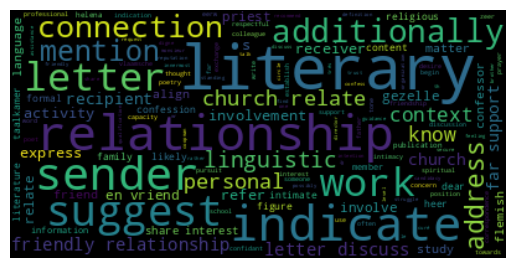

In [164]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=50).generate(input_wordcloud)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

🤔 Based on our little visualization, we can see that the model tried to make a couple of inferences (see the words "suggest", "mention" and "indicate"). The way the recipient of the letter was addressed (address) seemed to play a role in its interpretation of the letter - as well as the "context", which refers to the context information we fed to the prompt using our RAG-implementation.

# 🧐Visualize relationships in a network with Pyvis

Once we have our relationships per node (correspondent), we can visualize them in a Network visualization!


🧠 We also saved the number of letters that was present in the dataset per interlocutor pair. We did this because we want to create thicker edges for the stronger connections (= more correspondence).

In [101]:
df_merged["concat_rel"] = df_merged["relationships"].apply(lambda x: "_".join(sorted(x)))

In [102]:
edges = []

for _, row in df_merged.iterrows():
    edges.append((eval(row["sender"])[0], eval(row["receiver"])[0], {"relationship": row["concat_rel"], "value": row["letter_count"]}))

In [105]:
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True, cdn_resources="remote")

In [106]:
# Add nodes and edges to the network
for source, target, attributes in edges:
    net.add_node(source, label=source)
    net.add_node(target, label=target)
    net.add_edge(source, target, title=attributes['relationship'], label=attributes['relationship'], value= attributes["value"])

In [107]:
net.show_buttons(filter_=['physics'])
net.save_graph("Gezelle_graph.html")

In [112]:
display(HTML("graph_test.html"))